In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from init_objects import *
from functions.helpers import organise_data
from functions.inequality import gini, lorenz_curve
from distribution_model import *
import statsmodels.api as sm
from matplotlib import style
import scipy
from functions.find_bubbles import *
from statsmodels.iolib.summary2 import summary_col

In [2]:
style.use('ggplot')

# Detailed distributional consequences of speculation

Winners and losers: 
* chartists vs. fundamentalists 
* horizon 
* risk aversion 
* role of the short selling constraint 
* role of previous wealth.  
* role of timing

In [3]:
NRUNS = 1

In [41]:
with open('parameters.json', 'r') as f:
    params = json.loads(f.read())

In [43]:
params['ticks'] = 5000

In [44]:
burn_in_period = 0

In [51]:
trdrs = []
orbs = []
for seed in range(NRUNS): 
    traders, orderbook = init_objects_distr(params, seed)
    traders, orderbook = pb_distr_model(traders, orderbook, params, seed)
    trdrs.append(traders)
    orbs.append(orderbook)

Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  3
Start of simulation  4


## Organise data

In [6]:
wealth_starts = []
wealth_ends = []
ginis_ot = []
palmas_ot = []
twtws_ot = []
risk_aversions = []
horizons = []
learning_abilities = []
chartist_expectations = []
fundamentalist_expectations = []
profits = []

# determine the start and end wealth of the bubble
for seed, traders in enumerate(trdrs):
    money_start = np.array([x.var.money[0] for x in traders])
    stocks_start = np.array([x.var.stocks[0] for x in traders])
    wealth_start = money_start + (stocks_start * orbs[seed].tick_close_price[0])

    money_end = np.array([x.var.money[-1] for x in traders])
    stocks_end = np.array([x.var.stocks[-1] for x in traders])
    wealth_end = money_end + (stocks_end * orbs[seed].tick_close_price[-1])
    
    # profits
    profits.append((np.array(wealth_end) - np.array(wealth_start)) / np.array(wealth_start))

    # determine characteristics of the agents
    risk_aversions.append([x.par.risk_aversion for x in traders])
    horizons.append([x.par.horizon for x in traders])
    learning_abilities.append([x.par.learning_ability for x in traders])
    chartist_expectations.append([x.var.weight_chartist[: ] for x in traders])
    fundamentalist_expectations.append([x.var.weight_fundamentalist[:] for x in traders])

    wealth_gini_over_time = []
    palma_over_time = []
    twentytwenty_over_time = []
    for t in range(params['ticks']):
        money = np.array([x.var.money[t] for x in traders])
        stocks = np.array([x.var.stocks[t] for x in traders])
        wealth = money + (stocks * orderbook.tick_close_price[t])

        share_top_10 = sum(np.sort(wealth)[int(len(wealth) * 0.9):]) / sum(wealth)
        share_bottom_40 = sum(np.sort(wealth)[:int(len(wealth) * 0.4)]) / sum(wealth)
        palma_over_time.append(share_top_10 / share_bottom_40)

        share_top_20 = np.mean(np.sort(wealth)[int(len(wealth) * 0.8):])
        share_bottom_20 = np.mean(np.sort(wealth)[:int(len(wealth) * 0.2)])
        twentytwenty_over_time.append(share_top_20 / share_bottom_20)

        wealth_gini_over_time.append(gini(wealth))

    wealth_starts.append(list(wealth_start))
    wealth_ends.append(list(wealth_end))
    ginis_ot.append(wealth_gini_over_time)
    palmas_ot.append(palma_over_time)
    twtws_ot.append(twentytwenty_over_time)

NameError: name 'trdrs' is not defined

Add to a dataframe all data

In [5]:
all_profits = []
all_seeds = []
chart_exp = []
fund_exp = []
learn_ab = []
hors = []
rav = []
for idx, p in enumerate(profits):
    all_profits += list(p)
    learn_ab += learning_abilities[idx]
    hors += horizons[idx]
    rav += risk_aversions[idx]
    chart_exp += [np.mean(c_exp) for c_exp in chartist_expectations[idx]]
    fund_exp += [np.mean(f_exp) for f_exp in fundamentalist_expectations[idx]]
    all_seeds += [idx for c_exp in chartist_expectations[idx]]

NameError: name 'profits' is not defined

In [54]:
redistr_df = pd.DataFrame({'wealth_change': all_profits, 'seed': all_seeds, 'risk_av': rav, 
              'horizon': hors, 'learning': learn_ab, 'chart_exp': chart_exp, 'fund_exp': fund_exp})
redistr_df['const'] = 1

## Scatter plot analysis

NameError: name 'redistr_df' is not defined

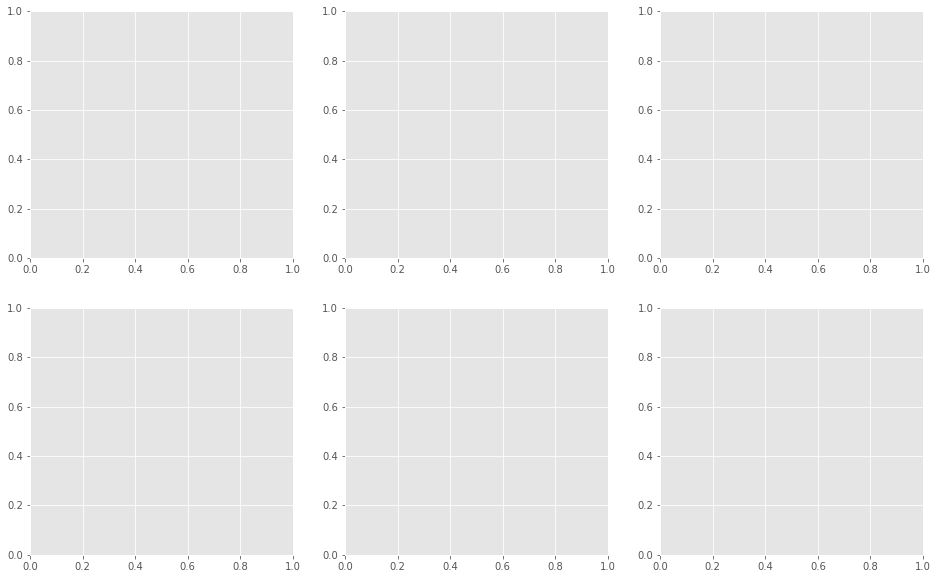

In [4]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=[16,10])

ax1.scatter(redistr_df['risk_av'], redistr_df['wealth_change'])
ax2.scatter(redistr_df['horizon'], redistr_df['wealth_change'])
ax3.scatter(redistr_df['learning'], redistr_df['wealth_change'])
ax4.scatter(redistr_df['chart_exp'], redistr_df['wealth_change'])
ax5.scatter(redistr_df['fund_exp'], redistr_df['wealth_change'])

ax1.set_xlabel('risk_av', fontsize=14)
ax2.set_xlabel('horizon', fontsize=14)
ax3.set_xlabel('learning', fontsize=14)
ax4.set_xlabel('chart_exp', fontsize=14)
ax5.set_xlabel('fund_exp', fontsize=14)